# Imports

In [1]:
import json

import joblib

import os

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

# Getting data

In [2]:
train_dataset = pd.read_csv('../datasets/classification_data/classification_train.csv')
test_dataset = pd.read_csv('../datasets/classification_data/classification_test.csv')

### Shuffle data

In [3]:
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

In [4]:
train_dataset.head(5)

,x1,x2,target
0,1.194505,-0.498167,1
1,-0.870737,-0.062688,0
2,0.307560,0.798304,0
3,0.521713,0.318790,0
4,1.207414,-1.135872,1


### Looking for outliers or inconsistencies

In [5]:
train_dataset.describe()

,x1,x2,target
count,670.000000,670.000000,670.000000
mean,0.481824,0.262611,0.505970
std,0.914772,0.615023,0.500338
min,-1.939767,-1.313970,0.000000
25%,-0.169615,-0.159189,0.000000
50%,0.492489,0.275538,1.000000
75%,1.159680,0.717589,1.000000
max,2.590410,1.904169,1.000000


In [6]:
test_dataset.describe()

,x1,x2,target
count,330.000000,330.000000,330.000000
mean,0.472470,0.266104,0.487879
std,0.986760,0.583819,0.500612
min,-1.693028,-1.031435,0.000000
25%,-0.264152,-0.190844,0.000000
50%,0.503077,0.240346,0.000000
75%,1.218472,0.680558,1.000000
max,2.528373,1.783693,1.000000


### Split validation dataset

In [7]:
split_size = int(len(train_dataset) * 0.1)
val_dataset = train_dataset.iloc[:split_size, :]
train_dataset = train_dataset.iloc[split_size:, :]

### Min Max scaling

In [8]:
scaler = MinMaxScaler()
scaler.fit(train_dataset)
train_dataset = pd.DataFrame(scaler.transform(train_dataset), columns=train_dataset.columns)
val_dataset = pd.DataFrame(scaler.transform(val_dataset), columns=val_dataset.columns)
test_dataset = pd.DataFrame(scaler.transform(test_dataset), columns=test_dataset.columns)

In [9]:
train_dataset.describe()

,x1,x2,target
count,603.000000,603.000000,603.000000
mean,0.536186,0.515149,0.510779
std,0.201184,0.200293,0.500299
min,0.000000,0.000000,0.000000
25%,0.394438,0.376372,0.000000
50%,0.537185,0.520101,1.000000
75%,0.685011,0.661610,1.000000
max,1.000000,1.000000,1.000000


### Setting dataloader

In [10]:
def get_dataloader(df, batch_size=10, shuffle=True):
    target = torch.tensor(df['target'].values.astype(np.float32))
    data = torch.tensor(df.drop('target', axis = 1).values.astype(np.float32)) 
    tensor = TensorDataset(data, target) 
    return DataLoader(dataset = tensor, batch_size = batch_size, shuffle = True)

# Modeling

In [11]:
class Net(nn.Module):
    def __init__(self, hidden_layer_size=256):
        super(Net, self).__init__()
        self.hid1 = nn.Linear(2, hidden_layer_size)
        self.hid2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.oupt = nn.Linear(hidden_layer_size, 1)

        nn.init.xavier_uniform_(self.hid1.weight) 
        nn.init.zeros_(self.hid1.bias)
        nn.init.xavier_uniform_(self.hid2.weight) 
        nn.init.zeros_(self.hid2.bias)
        nn.init.xavier_uniform_(self.oupt.weight)  
        nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = torch.tanh(self.hid1(x)) 
        x = torch.tanh(self.hid2(x))
        x = torch.sigmoid(self.oupt(x)) 
        return x

In [12]:
def __log__(epoch, lr, train_loss, val_loss=None):
    print("epoch {}".format(epoch))
    print("\ttraining loss:    {}".format(train_loss))
    if val_loss is not None:
        print("\tvalidation loss : {}".format(val_loss))
    print("\tlearning rate:    {}".format(lr))

class Model():
    def __init__(self):
        self.network = Net()
    
    def train(self, dataloader, val_dataloader=None, epochs=10, lr=0.001, log_epochs=10, patience=None):
        # setup learning rate
        # weight decay is an option so there must be 2 values
        if isinstance(lr, (list, tuple)):
            lr_bounds = lr[:2]
        else:
            lr_bounds = (lr, lr)
        lr = lr_bounds[0]
        
        # calculate number of steps(dataset length * number of epochs)
        steps = len(dataloader) * epochs
        
        # setup optimizer and loss function
        optimizer = torch.optim.SGD(self.network.parameters(), lr=lr)
        loss_function = nn.BCELoss()
        
        # keep loss so that it can be used to activate an early-stop mechanism(if patience is not None)
        val_losses = []

        for i in range(epochs):
            running_loss = 0.0
            running_val_loss = 0.0
            
            for x, y in dataloader:
                # zero param gradients
                optimizer.zero_grad()
                
                # calculate output and loss
                output = self.network(x)
                loss = loss_function(output, y.reshape(-1,1))
                
                # back-propagate
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # weight decay
                for g in optimizer.param_groups:
                    g['lr'] -= ((lr_bounds[0] - lr_bounds[1]) / steps)
                    lr -= ((lr_bounds[0] - lr_bounds[1]) / steps)

            if val_dataloader is None:
                __log__(i, lr, running_loss / len(train_dataloader))
                continue
                
            with torch.no_grad():
                for x, y in val_dataloader:
                    # zero param gradients
                    optimizer.zero_grad()

                    # calculate output and loss
                    output = self.network(x)
                    running_val_loss += loss_function(output, y.reshape(-1,1))
            __log__(i, lr, running_loss / len(train_dataloader), running_val_loss / len(val_dataloader))
            
            if patience is None:
                continue
                
            val_losses.append(running_val_loss)

            if len(val_losses) < patience + 1:
                continue
            val_losses = val_losses[-(patience + 1):]
            if val_losses.index(min(val_losses)) == 0:
                print('\nEARLY STOP')
                break


    def predict(self, dataloader):        
        predictions = []
        labels = []
        with torch.no_grad():
            for x, y in dataloader:
                # calculate output
                output = self.network(x)
                predicted = self.network(torch.tensor(x, dtype=torch.float32))

                predictions += predicted.reshape(-1).detach().numpy().round().tolist()
                labels += y

        return predictions, labels
    
    def test(self, dataloader):
        predictions, labels = self.predict(dataloader)
    
        counter = {
            'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0
        }
                
        for pred, lbl in zip(predictions, labels):
            if pred == 1 and lbl == 1: res = 'tp'
            elif pred == 1 and lbl == 0: res = 'fp'
            elif pred == 0 and lbl == 0: res = 'tn'
            else: res = 'fn'
            counter[res] += 1

        results = {
            'precision': counter['tp'] / (counter['tp'] + counter['fp']),
            'recall': counter['tp'] / (counter['tp'] + counter['fn'])
        }
        results['f1_score'] = \
            (2 * results['precision'] * results['recall']) / \
            (results['precision'] + results['recall'])
        
        return results
    
    def save(self, dir_path):
        torch.save(
            self.network.state_dict(),
            os.path.join(dir_path, 'weights')
        )


# Training

In [13]:
epochs = 200
hidden_layer_size = 256
batch_size = 10
learning_rate = 0.01
log_epochs = 1

train_dataloader = get_dataloader(train_dataset, batch_size=batch_size)
val_dataloader = get_dataloader(val_dataset, batch_size=batch_size)
test_dataloader = get_dataloader(test_dataset, batch_size=batch_size)

model = Model()
model.train(
    train_dataloader, val_dataloader=val_dataloader,
    epochs=epochs, lr=learning_rate, log_epochs=log_epochs,
    patience=int(epochs*0.1)
)

epoch 0
	training loss:    0.6800158649194435
	validation loss : 0.6575518846511841
	learning rate:    0.01
epoch 1
	training loss:    0.648031343202122
	validation loss : 0.6246320009231567
	learning rate:    0.01
epoch 2
	training loss:    0.6194437312298133
	validation loss : 0.5957816243171692
	learning rate:    0.01
epoch 3
	training loss:    0.5913253490064965
	validation loss : 0.5625170469284058
	learning rate:    0.01
epoch 4
	training loss:    0.5643074703021128
	validation loss : 0.5316867232322693
	learning rate:    0.01
epoch 5
	training loss:    0.5390741004318488
	validation loss : 0.5026623606681824
	learning rate:    0.01
epoch 6
	training loss:    0.5180547813900181
	validation loss : 0.4797614514827728
	learning rate:    0.01
epoch 7
	training loss:    0.49343893371644565
	validation loss : 0.45265477895736694
	learning rate:    0.01
epoch 8
	training loss:    0.47221136288564713
	validation loss : 0.42917531728744507
	learning rate:    0.01
epoch 9
	training loss:  

epoch 75
	training loss:    0.35938439628139873
	validation loss : 0.3040830194950104
	learning rate:    0.01
epoch 76
	training loss:    0.3593190956066866
	validation loss : 0.3040047287940979
	learning rate:    0.01
epoch 77
	training loss:    0.3589069835353093
	validation loss : 0.3040604293346405
	learning rate:    0.01
epoch 78
	training loss:    0.36145676403749183
	validation loss : 0.3215523362159729
	learning rate:    0.01
epoch 79
	training loss:    0.36817756710482424
	validation loss : 0.3055402636528015
	learning rate:    0.01
epoch 80
	training loss:    0.3591860151681744
	validation loss : 0.3107258975505829
	learning rate:    0.01
epoch 81
	training loss:    0.36963503013868804
	validation loss : 0.3087534010410309
	learning rate:    0.01
epoch 82
	training loss:    0.36118517901565206
	validation loss : 0.2937862277030945
	learning rate:    0.01
epoch 83
	training loss:    0.3632639834016073
	validation loss : 0.31790754199028015
	learning rate:    0.01
epoch 84
	tra

# Testing

In [14]:
results = model.test(test_dataloader)
results

/Users/joaomacedo/opt/anaconda3/envs/oncase/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'precision': 0.8081395348837209,
 'recall': 0.8633540372670807,
 'f1_score': 0.8348348348348347}

In [15]:
path = os.path.join('..', 'models', 'classification')

os.makedirs(path, exist_ok=True)

model.save(path)

with open(os.path.join(path, 'results.json'), 'w') as f:
    f.write(json.dumps(results, indent=4, ensure_ascii=False))

with open(os.path.join(path, 'train_info.json'), 'w') as f:
    f.write(json.dumps({
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'hidden_layer_size': hidden_layer_size
    }))
    
joblib.dump(scaler, os.path.join(path, 'min_max_scaler'))

['../models/classification/min_max_scaler']

# Feature impact

In [16]:
X = train_dataset.drop('target', axis = 1)
Y = train_dataset['target']

most_important_feature = SelectKBest(chi2, k=1).fit_transform(X, Y)

In [17]:
for k in X.keys():
    if most_important_feature[:, 0].tolist() == X[k].values.tolist():
        print(f'Most important feature: {k}')
        break

Most important feature: x2


A funcão SelectKBest roda uma analise estatisticas univariada para definir quais variaveis tem um maior impacto no target.

([<matplotlib.axis.XTick at 0x7f8103f49890>,
 [Text(0, 0, 'x1'), Text(1, 0, 'x2')])

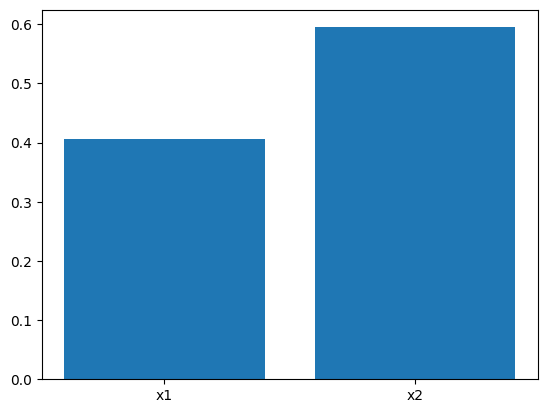

In [18]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X, Y)

plt.bar(range(X.shape[1]), gb.feature_importances_)
plt.xticks(range(X.shape[1]), ['x1','x2'])

Utilizando o modelo GradientBoostingClassifier podemos ver que ele também aponta que a variavel de maior importancia é a variavel x2.